In [1]:
%matplotlib inline

In [97]:
def get_model_results(history):
    from matplotlib import pyplot as plt
    acc = history.history['mean_absolute_error']
    val_acc = history.history['val_mean_absolute_error']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = [i for i in range(1,len(loss)+1)]
    print(('mae = %0.2f, loss = %0.2f ')%(max(acc),min(loss)))
    print(('val_mae = %0.2f, val_loss = %0.2f ')%(max(acc),min(val_loss)))
    
    plt.figure()
    plt.plot(epochs,acc,'bo',label = 'Training acc')
    plt.plot(epochs,val_acc,'b',label = 'Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs,loss,'bo',label = 'Training loss')
    plt.plot(epochs,val_loss,'b',label = 'Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [82]:
from pandas import read_csv
from keras.models import Model
from keras import layers
from keras.optimizers import RMSprop,Adam
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from numpy import random

In [5]:
data = read_csv('../datasets/BostonHousing.csv')

In [6]:
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


### Attributes

>CRIM: per capita crime rate by town.
>
>ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
>
>INDUS: proportion of non-retail business acres per town.
>
>CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
>
>NOX: nitric oxides concentration (parts per 10 million).
>
>RM: average number of rooms per dwelling.
>
>AGE: proportion of owner-occupied units built prior to 1940.
>
>DIS: weighted distances to ﬁve Boston employment centers.
>
>RAD: index of accessibility to radial highways.
>
>TAX: full-value property-tax rate per 10,000 dollars.
>
>PTRATIO: pupil-teacher ratio by town.
>
>B: 1000(Bk−0.63)^2 where Bk is the proportion of blacks by town.
>
>LSTAT: Percent lower status of the population.
>
>MEDV: Median value of owner-occupied homes in thousand dollars.

### Model definition using a function

In [88]:
def build_nn_model(optimizer=Adam(lr=0.0001), init='normal'):
    input_data = layers.Input(shape=(13,))
    x = layers.Dense(9,kernel_initializer=init,activation = 'relu')(input_data)
    x = layers.Dense(5,kernel_initializer=init,activation = 'relu')(x)
    x = layers.Dense(1,kernel_initializer=init)(x)
    model_mlp = Model(input_data,x)
    model_mlp.compile(optimizer=optimizer, loss = 'mse', metrics = ['mae'])
    return(model_mlp)

### Running the model using a usual validation split

In [116]:
model = build_nn_model()
X = data.values[:,:-1]
Y = data.values[:,-1]
history = model.fit(X,
                    Y,
                    epochs=100,
                    batch_size=1,
                    validation_split=0.1,
                    verbose=False)

mae = 11.04, loss = 18.02 
val_mae = 11.04, val_loss = 17.01 


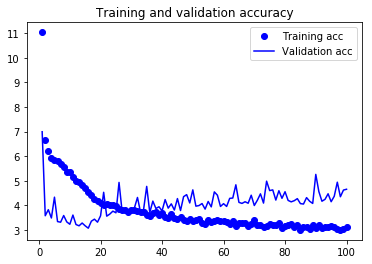

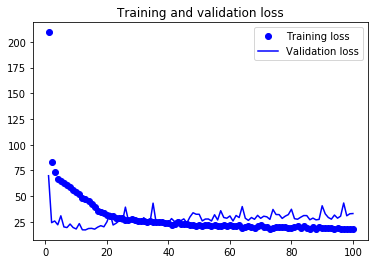

In [118]:
get_model_results(history)
#batch_size = 1
#mae = 9.37, loss = 16.68 
#val_mae = 9.37, val_loss = 18.56

### Pipeline definition

In [68]:
seed = 1234
random.seed(seed)
kfold = KFold(n_splits=10, random_state=seed)
X = data.values[:,:-1]
Y = data.values[:,-1]

estimators = []
estimators.append(('standarize',StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=build_nn_model, epochs=100, batch_size=1, verbose=0)))

pipeline = Pipeline(estimators)

### Using Cross-Validation

In [72]:
results = cross_val_score(pipeline, X, Y, cv=kfold)

In [73]:
print("MSE: %.2f (%.2f) MSE" % (results.mean(), results.std()))

MSE: -47.71 (43.24) MSE


In [74]:
# Fit the pipeline
pipeline.fit(X, Y)

# Pipeline test accuracy
print('Test accuracy: %.3f' % pipeline.score(X, Y))

Test accuracy: -33.073


In [78]:
print('\nModel hyperparameters:\n', pipeline.steps[1][1].get_params())


Model hyperparameters:
 {'epochs': 10, 'batch_size': 5, 'verbose': 0, 'build_fn': <function build_nn_model at 0x7f1760127950>}


## Hyperparameter search / Grid Search

### GridSearch for a pipeline model

In [155]:
def build_nn_model(optimizer='adam', init='normal'):
    input_data = layers.Input(shape=(13,))
    x = layers.Dense(9,kernel_initializer=init,activation = 'relu')(input_data)
    x = layers.Dense(5,kernel_initializer=init,activation = 'relu')(x)
    x = layers.Dense(1,kernel_initializer=init)(x)
    model_mlp = Model(input_data,x)
    model_mlp.compile(optimizer=optimizer, loss = 'mse', metrics = ['mae'])
    return(model_mlp)

seed = 1234
random.seed(seed)
X = data.values[:,:-1]
Y = data.values[:,-1]
estimators = [('standarize',StandardScaler()),
              ('mlp', KerasRegressor(build_fn=build_nn_model,verbose=0))]##epochs=10, batch_size=5, 
pipeline = Pipeline(estimators)
param_grid = [{'mlp__optimizer':['adam'], #'rmsprop',
               'mlp__init' : ['normal', 'uniform'], # 'glorot_uniform',
               'mlp__epochs' : [100],
               'mlp__batch_size' : [1, 20]}]

In [ ]:
# Construct grid search
gs = GridSearchCV(estimator=pipeline,
                  param_grid=param_grid,
                  scoring='neg_mean_squared_error',
                  cv=10)

# Fit using grid search
gs.fit(X, Y)

# Best accuracy
print('Best accuracy: %.3f' % gs.best_score_)

# Best params
print('\nBest params:\n', gs.best_params_)

In [ ]:
print("Best: %f using %s" % (gs.best_score_, gs.best_params_))
for mean, stdev, param in zip(gs.cv_results_['mean_test_score'],
                              gs.cv_results_['std_test_score'],
                              gs.cv_results_['params']):
    print("%f (%f) with: %r" % (mean, stdev, param))

### GridSearch for a stand-alone model - outside of a pipeline -

In [142]:
# Model from keras
model = KerasRegressor(build_fn=build_nn_model, verbose=0)

# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam']
init = ['glorot_uniform', 'normal', 'uniform']
epochs = [50, 100, 150]
batches = [5, 10, 20]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=init)

In [ ]:
grid = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    scoring = 'neg_mean_squared_error',
                    cv = 10)
grid_result = grid.fit(X, Y)

In [90]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r"%(mean, stdev, param))

Best: -59.377167 using {'batch_size': 20, 'epochs': 100, 'init': 'normal', 'optimizer': 'adam'}
-121.288910 (67.114416) with: {'batch_size': 5, 'epochs': 50, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
-183.658480 (184.046859) with: {'batch_size': 5, 'epochs': 50, 'init': 'glorot_uniform', 'optimizer': 'adam'}
-288.512443 (298.913446) with: {'batch_size': 5, 'epochs': 50, 'init': 'normal', 'optimizer': 'rmsprop'}
-73.541001 (36.442183) with: {'batch_size': 5, 'epochs': 50, 'init': 'normal', 'optimizer': 'adam'}
-71.963635 (26.691244) with: {'batch_size': 5, 'epochs': 50, 'init': 'uniform', 'optimizer': 'rmsprop'}
-67.963955 (33.261319) with: {'batch_size': 5, 'epochs': 50, 'init': 'uniform', 'optimizer': 'adam'}
-467.118483 (582.833303) with: {'batch_size': 5, 'epochs': 100, 'init': 'glorot_uniform', 'optimizer': 'rmsprop'}
-426.956852 (534.430674) with: {'batch_size': 5, 'epochs': 100, 'init': 'glorot_uniform', 'optimizer': 'adam'}
-391.964961 (309.949950) with: {'batch_size': 5

### Model Ensemble 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

In [ ]:
def build_nn_model(optimizer='adam', init='normal'):
    input_data = layers.Input(shape=(13,))
    x = layers.Dense(9,kernel_initializer=init,activation = 'relu')(input_data)
    x = layers.Dense(5,kernel_initializer=init,activation = 'relu')(x)
    x = layers.Dense(1,kernel_initializer=init)(x)
    model_mlp = Model(input_data,x)
    model_mlp.compile(optimizer=optimizer, loss = 'mse', metrics = ['mae'])
    return(model_mlp)

seed = 1234
random.seed(seed)
X = data.values[:,:-1]
Y = data.values[:,-1]

estimators = [('standarize',StandardScaler()),
              ('mlp', KerasRegressor(build_fn=build_nn_model,verbose=0)),
              ('logistic', LogisticRegression()),
              ('cart', DecisionTreeClassifier()),
              ('svm', SVC())]
pipeline = Pipeline(estimators)

In [ ]:
ensemble = VotingClassifier(estimators)
results = model_selection.cross_val_score(ensemble, X, Y, cv=kfold)
print(results.mean())